## <a name="abstract">Titanic Machine Learning From Disaster</a>

Abstract The sinking of the RMS Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.
One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.
In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

In [4]:
using DataFrames
using DecisionTree
using MLBase
using Gadfly

  likely near /Users/diego/.julia/v0.4/MLBase/src/modeltune.jl:5
  likely near /Users/diego/.julia/v0.4/MLBase/src/modeltune.jl:5
  likely near /Users/diego/.julia/v0.4/MLBase/src/modeltune.jl:5
  likely near /Users/diego/.julia/v0.4/MLBase/src/deprecated/datapre.jl:104
  likely near /Users/diego/.julia/v0.4/MLBase/src/deprecated/datapre.jl:105
  likely near /Users/diego/.julia/v0.4/MLBase/src/deprecated/datapre.jl:163
  likely near /Users/diego/.julia/v0.4/MLBase/src/deprecated/datapre.jl:163
  likely near /Users/diego/.julia/v0.4/MLBase/src/deprecated/datapre.jl:163


## Load Data

In [5]:
train = readtable("data/train.csv")
test = readtable("data/test.csv");

### Handle Missing Data

In [7]:
showcols(train)
showcols(test)

891x12 DataFrames.DataFrame
| Col # | Name        | Eltype     | Missing |
|-------|-------------|------------|---------|
| 1     | PassengerId | Int64      | 0       |
| 2     | Survived    | Int64      | 0       |
| 3     | Pclass      | Int64      | 0       |
| 4     | Name        | UTF8String | 0       |
| 5     | Sex         | UTF8String | 0       |
| 6     | Age         | Float64    | 177     |
| 7     | SibSp       | Int64      | 0       |
| 8     | Parch       | Int64      | 0       |
| 9     | Ticket      | UTF8String | 0       |
| 10    | Fare        | Float64    | 0       |
| 11    | Cabin       | UTF8String | 687     |
| 12    | Embarked    | UTF8String | 2       |418x11 DataFrames.DataFrame
| Col # | Name        | Eltype     | Missing |
|-------|-------------|------------|---------|
| 1     | PassengerId | Int64      | 0       |
| 2     | Pclass      | Int64      | 0       |
| 3     | Name        | UTF8String | 0       |
| 4     | Sex         | UTF8String | 0       |
| 5  

In [8]:
most_frequenty_embarked_class = "S"
average_fare = mean(train[!isna(train[:Fare]), :Fare]);

In [9]:
train[isna(train[:Embarked]), :Embarked] = most_frequenty_embarked_class
test[isna(test[:Embarked]), :Embarked] = most_frequenty_embarked_class
test[isna(test[:Fare]), :Fare] = average_fare;

#### Infered Age with Regression Trees

In [10]:
data = vcat(train, test) 

age_features = [:Pclass, :Sex, :SibSp, :Parch, :Fare]
age_training_features = array(data[!isna(data[:Age]), age_features])
age_training_labels = array(data[!isna(data[:Age]), :Age])

model = build_tree(age_training_labels, age_training_features, 5)
train[isna(train[:Age]), :Age] = apply_tree(model, array(train[isna(train[:Age]), age_features]))
test[isna(test[:Age]), :Age] = apply_tree(model, array(test[isna(test[:Age]), age_features]));

 in depwarn at deprecated.jl:73
 in array at deprecated.jl:50
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /Users/diego/.julia/v0.4/IJulia/src/execute_request.jl:177
 in eventloop at /Users/diego/.julia/v0.4/IJulia/src/IJulia.jl:141
 in anonymous at task.jl:447
while loading In[10], in expression starting on line 4


### Add New Features

#### Feature 1: Title

In [11]:
title_sir = ["Capt", "Don", "Major", "Master", "Sir", "Dr"]
title_lady = ["Don", "Lady", "the Countess", "Jonkheer"]
training_title_list = map(n -> split(strip(split(n, ",")[2]), ".")[1], train[:Name])
test_title_list = map(n -> split(strip(split(n, ",")[2]), ".")[1], test[:Name])
countmap(training_title_list)

 in depwarn at deprecated.jl:73
 in array at deprecated.jl:50
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /Users/diego/.julia/v0.4/IJulia/src/execute_request.jl:177
 in eventloop at /Users/diego/.julia/v0.4/IJulia/src/IJulia.jl:141
 in anonymous at task.jl:447
while loading In[10], in expression starting on line 8


Dict{Any,Int64} with 17 entries:
  "Jonkheer"     => 1
  "Don"          => 1
  "the Countess" => 1
  "Master"       => 40
  "Miss"         => 182
  "Capt"         => 1
  "Mrs"          => 125
  "Rev"          => 6
  "Major"        => 2
  "Mr"           => 517
  "Mme"          => 1
  "Mlle"         => 2
  "Col"          => 2
  "Lady"         => 1
  "Sir"          => 1
  "Ms"           => 1
  "Dr"           => 7

In [12]:
is_in_title_list(names, title_list) = Array{Bool}(map(n -> n in title_list, names))
train[:Title] = training_title_list
train[is_in_title_list(training_title_list, title_sir), :Title] = "Sir."
train[is_in_title_list(training_title_list, title_lady), :Title] = "Lady."
test[:Title] = test_title_list
test[is_in_title_list(test_title_list, title_sir), :Title] = "Sir."
test[is_in_title_list(test_title_list, title_lady), :Title] = "Lady.";

#### Feature 2: Family Size

In [13]:
train[:FamilySize] = train[:Parch] .+ train[:SibSp] .+ 1
test[:FamilySize] = test[:Parch] .+ test[:SibSp] .+ 1;

#### Feature 3: Is Mother?

In [14]:
is_mother(df) = Array{Bool}(map(i -> df[i, :Parch] > 0 && df[i, :Age] > 18 && df[i, :Title] != "Miss", vcat(1:size(df,1))))
train[:IsMother] = 0
train[is_mother(train), :IsMother] = 1
test[:IsMother] = 0
test[is_mother(test), :IsMother] = 1;

#### Feature 4: Is Child?

In [15]:
is_child(df) = Array{Bool}(map(i -> df[i, :Parch] > 0 && df[i, :Age] <= 18, size(df,1)))
train[:IsChild] = 0
train[is_child(train), :IsChild] = 1
test[:IsChild] = 0
test[is_child(test), :IsChild] = 1;

#### Feature 5: Family Size 2

In [16]:
get_surname(name) = strip(split(name, ",")[1])
surname_freq = countmap(map(n -> get_surname(n), vcat(train[:Name], test[:Name])))
is_small_family(names) = map(n -> surname_freq[get_surname(n)] > 2? 0 : 1, names);
train[:IsSmallFamily] = is_small_family(train[:Name])
test[:IsSmallFamily] = is_small_family(test[:Name]);

#### Features 6-7: Cabin Prefix and Number

In [17]:
#get_cabin_prefix(cabins) = Array{AbstractString}(map(c -> !isna(c)? string(c[1]) : "NA", cabins))
get_cabin_prefix(cabins) = map(c -> !isna(c)? string(c[1]) : NA, cabins)
get_cabin_number(cabins) = Array{AbstractString}(map(c ->  !isna(c)? string(c[2:end]) : "-1", cabins))
train[:CabinPrefix] = get_cabin_prefix(train[:Cabin])
train[:CabinNumber] = get_cabin_number(train[:Cabin])
test[:CabinPrefix] = get_cabin_prefix(test[:Cabin])
test[:CabinNumber] = get_cabin_number(test[:Cabin]);

In [18]:
data = vcat(train, test)
cabin_prefix_labels = labelmap(Array{AbstractString}(dropna(data[:CabinPrefix])));

train[!isna(train[:CabinPrefix]), :CabinPrefix] = labelencode(cabin_prefix_labels, Array{AbstractString}(train[!isna(train[:CabinPrefix]), :CabinPrefix]))
test[!isna(test[:CabinPrefix]), :CabinPrefix] = labelencode(cabin_prefix_labels, Array{AbstractString}(test[!isna(test[:CabinPrefix]), :CabinPrefix]))
data[!isna(data[:CabinPrefix]), :CabinPrefix] = labelencode(cabin_prefix_labels, Array{AbstractString}(data[!isna(data[:CabinPrefix]), :CabinPrefix]));

In [19]:
cabin_prefix_features = [:Pclass, :Sex, :Age, :SibSp, :Parch, :Fare, :Embarked, 
                         :Title, :FamilySize, :IsMother, :IsChild, :IsSmallFamily]
cabin_prefix_training_features = array(data[!isna(data[:CabinPrefix]), cabin_prefix_features])
cabin_prefix_training_labels = array(data[!isna(data[:CabinPrefix]), :CabinPrefix])

model = build_tree(cabin_prefix_training_labels, cabin_prefix_training_features, 5)
train[isna(train[:CabinPrefix]), :CabinPrefix] = apply_tree(model, array(train[isna(train[:CabinPrefix]), cabin_prefix_features]))
test[isna(test[:CabinPrefix]), :CabinPrefix] = apply_tree(model, array(test[isna(test[:CabinPrefix]), cabin_prefix_features]));

### Prepare Training/Validation Set

In [20]:
features_names = [:Pclass, :Sex, :Age, :SibSp, :Parch, :Fare, :Embarked, 
                  :Title, :FamilySize, :IsMother, :IsChild, :IsSmallFamily, 
                  :CabinPrefix, :CabinNumber]
training_features = array(train[:, features_names])
training_labels = array(train[:, :Survived])
test_features = array(test[:, features_names]);

### Training & Evaluation

In [26]:
average_time = 10
cv = 5
random_features = []
number_trees = []
splits = []
accs = []
iteration = 0
nt=100
sp=.7
for rf=1:10
    iteration += 1
    average_acc = mean(nfoldCV_forest(training_labels, training_features, rf, nt, cv, sp))
    println("Iteration $iteration: RF:$rf, NT:$nt, SP:$sp, AVG_ACC: $(round(average_acc*100, 2))")
    push!(random_features, rf)
    push!(number_trees, nt)
    push!(splits, sp)
    push!(accs, average_acc)
end


Fold 1

2x2 Array{Int64,2}:
 107   2
  41  28


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.7584269662921348
Kappa:    0.4322800771398901

Fold 2

2x2 Array{Int64,2}:
 107   0
  45  26


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.7471910112359551
Kappa:    0.4099012818623841

Fold 3

2x2 Array{Int64,2}:
 101   7
  37  33


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.7528089887640449
Kappa:    0.43977110157367655

Fold 4

2x2 Array{Int64,2}:
 107   3
  33  35


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.797752808988764
Kappa:    0.5322627737226275

Fold 5

2x2 Array{Int64,2}:
 105   9
  29  35


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.7865168539325843
Kappa:    0.5023543260741614

Mean Accuracy: 0.7685393258426967
Iteration 1: RF:1, NT:100, SP:0.7, AVG_ACC: 76.85

Fold 1

2x2 Array{Int64,2}:
 96   9
 23  50


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8202247191011236
Kappa:    0.6172557451955382

Fold 2

2x2 Array{Int64,2}:
 95  21
 15  47


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.797752808988764
Kappa:    0.5643187381017133

Fold 3

2x2 Array{Int64,2}:
 99  12
 15  52


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.848314606741573
Kappa:    0.6739926739926739

Fold 4

2x2 Array{Int64,2}:
 101  15
  14  48


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8370786516853933
Kappa:    0.6424712564067047

Fold 5

2x2 Array{Int64,2}:
 96   5
 30  47


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8033707865168539
Kappa:    0.5833890597833354

Mean Accuracy: 0.8213483146067416
Iteration 2: RF:2, NT:100, SP:0.7, AVG_ACC: 82.13

Fold 1

2x2 Array{Int64,2}:
 91  20
 13  54


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8146067415730337
Kappa:    0.6130944539586353

Fold 2

2x2 Array{Int64,2}:
 108  12
  25  33


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.7921348314606742
Kappa:    0.49778862284581377

Fold 3

2x2 Array{Int64,2}:
 102  14
  17  45


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8258426966292135
Kappa:    0.6120095626494164

Fold 4

2x2 Array{Int64,2}:
 85  12
 23  58


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8033707865168539
Kappa:    0.5990474964602908

Fold 5

2x2 Array{Int64,2}:
 95   9
 25  49


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8089887640449438
Kappa:    0.5941523605150214

Mean Accuracy: 0.8089887640449438
Iteration 3: RF:3, NT:100, SP:0.7, AVG_ACC: 80.9

Fold 1

2x2 Array{Int64,2}:
 94  10
 23  51


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8146067415730337
Kappa:    0.6084522063724837

Fold 2

2x2 Array{Int64,2}:
 102  13
  11  52


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8651685393258427
Kappa:    0.7072769631355351

Fold 3

2x2 Array{Int64,2}:
 92  12
 19  55


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8258426966292135
Kappa:    0.6365432749308392

Fold 4

2x2 Array{Int64,2}:
 102  10
  27  39


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.7921348314606742
Kappa:    0.5296386230538496

Fold 5

2x2 Array{Int64,2}:
 101  12
  16  49


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8426966292134831
Kappa:    0.6562284453028002

Mean Accuracy: 0.8280898876404494
Iteration 4: RF:4, NT:100, SP:0.7, AVG_ACC: 82.81

Fold 1

2x2 Array{Int64,2}:
 97   8
 20  53


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8426966292134831
Kappa:    0.6665328515990899

Fold 2

2x2 Array{Int64,2}:
 89  19
 20  50


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.7808988764044944
Kappa:    0.5397162180082218

Fold 3

2x2 Array{Int64,2}:
 106   6
  20  46


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8539325842696629
Kappa:    0.6727015558698727

Fold 4

2x2 Array{Int64,2}:
 100  14
  17  47


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8258426966292135
Kappa:    0.6179199556848083

Fold 5

2x2 Array{Int64,2}:
 98  11
 20  49


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8258426966292135
Kappa:    0.6241656450074922

Mean Accuracy: 0.8258426966292134
Iteration 5: RF:5, NT:100, SP:0.7, AVG_ACC: 82.58

Fold 1

2x2 Array{Int64,2}:
 93   8
 23  54


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8258426966292135
Kappa:    0.6368303277609584

Fold 2

2x2 Array{Int64,2}:
 101  13
  13  51


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8539325842696629
Kappa:    0.6828399122807017

Fold 3

2x2 Array{Int64,2}:
 104  16
  15  43


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8258426966292135
Kappa:    0.6053497353740525

Fold 4

2x2 Array{Int64,2}:
 95  13
 16  54


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8370786516853933
Kappa:    0.6560042649606824

Fold 5

2x2 Array{Int64,2}:
 95  10
 24  49


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8089887640449438
Kappa:    0.5933342292702593

Mean Accuracy: 0.8303370786516855
Iteration 6: RF:6, NT:100, SP:0.7, AVG_ACC: 83.03

Fold 1

2x2 Array{Int64,2}:
 101  10
  23  44


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8146067415730337
Kappa:    0.5892882114389596

Fold 2

2x2 Array{Int64,2}:
 105   7
  19  47


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8539325842696629
Kappa:    0.6748173130972456

Fold 3

2x2 Array{Int64,2}:
 93  11
 22  52


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8146067415730337
Kappa:    0.6100119506041695

Fold 4

2x2 Array{Int64,2}:
 94   9
 19  56


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8426966292134831
Kappa:    0.6714568226763348

Fold 5

2x2 Array{Int64,2}:
 98  20
 12  48


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8202247191011236
Kappa:    0.6105032822757112

Mean Accuracy: 0.8292134831460676
Iteration 7: RF:7, NT:100, SP:0.7, AVG_ACC: 82.92

Fold 1

2x2 Array{Int64,2}:
 85  14
 16  63


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8314606741573034
Kappa:    0.6577361876682477

Fold 2

2x2 Array{Int64,2}:
 99  11
 16  52


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.848314606741573
Kappa:    0.6741694915254237

Fold 3

2x2 Array{Int64,2}:
 103  10
  19  46


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8370786516853933
Kappa:    0.6379576378173658

Fold 4

2x2 Array{Int64,2}:
 105   6
  18  49


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8651685393258427
Kappa:    0.7022166457549143

Fold 5

2x2 Array{Int64,2}:
 102  13
  19  44


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8202247191011236
Kappa:    0.5982508111158132

Mean Accuracy: 0.8404494382022472
Iteration 8: RF:8, NT:100, SP:0.7, AVG_ACC: 84.04

Fold 1

2x2 Array{Int64,2}:
 99   5
 22  52


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.848314606741573
Kappa:    0.6770595350087353

Fold 2

2x2 Array{Int64,2}:
 102  15
  17  44


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8202247191011236
Kappa:    0.5977969213387939

Fold 3

2x2 Array{Int64,2}:
 88  13
 24  53


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.7921348314606742
Kappa:    0.5692609548724658

Fold 4

2x2 Array{Int64,2}:
 103  12
  12  51


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8651685393258427
Kappa:    0.7051759834368531

Fold 5

2x2 Array{Int64,2}:
 101  10
  11  56


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8820224719101124
Kappa:    0.7479433580579906

Mean Accuracy: 0.8415730337078653
Iteration 9: RF:9, NT:100, SP:0.7, AVG_ACC: 84.16

Fold 1

2x2 Array{Int64,2}:
 100  11
  19  48


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8314606741573034
Kappa:    0.6322820548133866

Fold 2

2x2 Array{Int64,2}:
 86  16
 19  57


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8033707865168539
Kappa:    0.5961363931025541

Fold 3

2x2 Array{Int64,2}:
 96  10
 22  50


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8202247191011236
Kappa:    0.6165858912224017

Fold 4

2x2 Array{Int64,2}:
 109  10
  15  44


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8595505617977528
Kappa:    0.6761752292242759

Fold 5

2x2 Array{Int64,2}:
 96  14
 20  48


Classes:  Any[0,1]
Matrix:   
Accuracy: 0.8089887640449438
Kappa:    0.5885232526516181

Mean Accuracy: 0.8247191011235955
Iteration 10: RF:10, NT:100, SP:0.7, AVG_ACC: 82.47


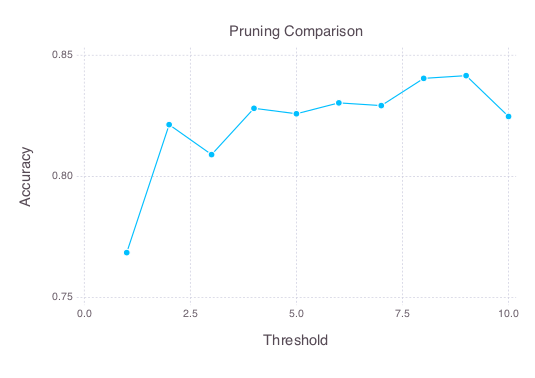

In [33]:
plot(x=vcat(1:10), y=accs, Geom.point, Geom.line, Guide.xlabel("Threshold"), Guide.ylabel("Accuracy"), Guide.title("Pruning Comparison"))

### Use Best Evaluated Model to Predict

In [31]:
model = build_forest(training_labels, training_features, 5, 600, .7)
predicted_values = apply_forest(model, test_features);

### Save Best Model

In [32]:
prediction_dataframe = DataFrame(PassengerId=test[:PassengerId], Survived=predicted_values)
writetable("./data/prediction_v6_random_forest_5randfeat_600trees_.7split_cv5_feat_engineering.csv", prediction_dataframe);

### Results on Kaggle

<div style="background-color:#c1f5ba; color:#30b171; padding:5px;
            font-family:'Lucida Sans Unicode', 'Lucida Grande', sans-serif">
    Results from this submission on Kaggle: **0.78469**
</div>